In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm  import LGBMRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error
from model import *
%load_ext autoreload
%autoreload 2

In [2]:
pd.set_option('display.max.columns', 500)
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [3]:
train_df = pd.read_csv('train_dataset/train_dataset.csv')
test_df = pd.read_csv('test_dataset/test_dataset.csv')

In [4]:
train_df.head()

,用户编码,用户实名制是否通过核实,用户年龄,是否大学生客户,是否黑名单客户,是否4G不健康客户,用户网龄（月）,用户最近一次缴费距今时长（月）,缴费用户最近一次缴费金额（元）,用户近6个月平均消费值（元）,用户账单当月总费用（元）,用户当月账户余额（元）,缴费用户当前是否欠费缴费,用户话费敏感度,当月通话交往圈人数,是否经常逛商场的人,近三个月月均商场出现次数,当月是否逛过福州仓山万达,当月是否到过福州山姆会员店,当月是否看电影,当月是否景点游览,当月是否体育场馆消费,当月网购类应用使用次数,当月物流快递类应用使用次数,当月金融理财类应用使用总次数,当月视频播放类应用使用次数,当月飞机类应用使用次数,当月火车类应用使用次数,当月旅游资讯类应用使用次数,信用分
0,a4651f98c82948b186bdcdc8108381b4,1,44,0,0,0,186,1,99.80,163.86,159.20,180,0,3,83,1,75,0,0,0,1,1,713,0,2740,7145,0,0,30,664
1,aeb10247db4e4d67b2550bbc42ff9827,1,18,0,0,1,5,1,29.94,153.28,145.10,110,0,3,21,1,16,0,0,0,0,0,414,0,2731,44862,0,0,0,530
2,5af23a1e0e77410abb25e9a7eee510aa,1,47,0,0,0,145,1,49.90,109.64,120.20,70,0,1,59,0,1,0,0,0,0,0,3391,0,0,4804,0,0,1,643
3,43c64379d3c24a15b8478851b22049e4,1,55,0,0,0,234,1,99.80,92.97,167.42,90,0,3,78,1,26,0,0,0,1,1,500,0,1931,3141,0,0,5,649
4,f1687f3b8a6f4910bd0b13eb634056e2,1,40,0,0,0,76,1,49.90,95.47,101.00,80,0,3,70,1,44,0,0,0,1,0,522,0,64,59,0,0,0,648


count    50000.000000
mean       618.053060
std         42.443022
min        422.000000
25%        594.000000
50%        627.000000
75%        649.000000
max        719.000000
Name: 信用分, dtype: float64


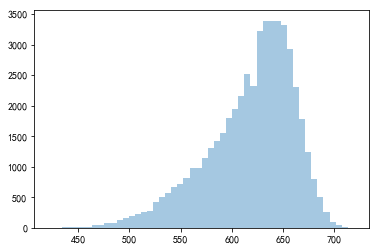

In [5]:
print(train_df['信用分'].describe())
sns.distplot(train_df['信用分'].values, bins=50, kde=False)

大部分数据集中在600到680之间，呈左偏分布。先做 baseline，再尝试对数据做正态分布转换。

In [6]:
train_df['信用分'].skew()

-0.8636696514885482

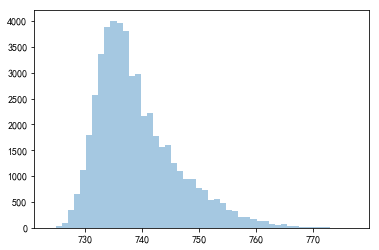

In [7]:
sns.distplot(np.log1p(1/train_df['信用分'].values*1e6)*100, bins=50, kde=False)

In [8]:
pd.Series(np.log1p(1/train_df['信用分'].values*1e6)*100).skew()

1.068423854945718

# 数据探索分析

In [9]:
y_train = train_df['信用分']
train_test = pd.concat((train_df.drop('信用分', axis=1), test_df))

In [10]:
train_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 49999
Data columns (total 29 columns):
用户编码               100000 non-null object
用户实名制是否通过核实        100000 non-null int64
用户年龄               100000 non-null int64
是否大学生客户            100000 non-null int64
是否黑名单客户            100000 non-null int64
是否4G不健康客户          100000 non-null int64
用户网龄（月）            100000 non-null int64
用户最近一次缴费距今时长（月）    100000 non-null int64
缴费用户最近一次缴费金额（元）    100000 non-null float64
用户近6个月平均消费值（元）     100000 non-null float64
用户账单当月总费用（元）       100000 non-null float64
用户当月账户余额（元）        100000 non-null int64
缴费用户当前是否欠费缴费       100000 non-null int64
用户话费敏感度            100000 non-null int64
当月通话交往圈人数          100000 non-null int64
是否经常逛商场的人          100000 non-null int64
近三个月月均商场出现次数       100000 non-null int64
当月是否逛过福州仓山万达       100000 non-null int64
当月是否到过福州山姆会员店      100000 non-null int64
当月是否看电影            100000 non-null int64
当月是否景点游览           100000 non-null int64
当月是否体育场馆消费         100

所有数据没有缺失值，只有一个字符串形式的特征

In [11]:
train_test.describe()

,用户实名制是否通过核实,用户年龄,是否大学生客户,是否黑名单客户,是否4G不健康客户,用户网龄（月）,用户最近一次缴费距今时长（月）,缴费用户最近一次缴费金额（元）,用户近6个月平均消费值（元）,用户账单当月总费用（元）,用户当月账户余额（元）,缴费用户当前是否欠费缴费,用户话费敏感度,当月通话交往圈人数,是否经常逛商场的人,近三个月月均商场出现次数,当月是否逛过福州仓山万达,当月是否到过福州山姆会员店,当月是否看电影,当月是否景点游览,当月是否体育场馆消费,当月网购类应用使用次数,当月物流快递类应用使用次数,当月金融理财类应用使用总次数,当月视频播放类应用使用次数,当月飞机类应用使用次数,当月火车类应用使用次数,当月旅游资讯类应用使用次数
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.00000,1.000000e+05,100000.000000,100000.000000,100000.000000
mean,0.991240,37.907910,0.003620,0.048500,0.088690,96.271580,0.701420,53.721932,98.983241,99.709021,115.684600,0.051830,3.352980,48.211110,0.330720,26.507030,0.039230,0.02705,0.243800,0.47546,0.374730,1161.142610,1.025860,975.36609,3.386321e+03,0.649760,0.564590,19.394650
std,0.093184,11.625008,0.060058,0.214821,0.284297,59.112782,0.457637,62.214807,61.002422,65.314169,448.684984,0.221685,1.241129,54.867465,0.470475,32.739661,0.194143,0.16223,0.429376,0.49940,0.484056,4300.092242,37.482212,2965.36056,1.074417e+04,22.299903,7.973381,312.587384
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,10.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000e+00,0.000000,0.000000,0.000000
25%,1.000000,30.000000,0.000000,0.000000,0.000000,48.000000,0.000000,0.000000,54.320000,53.000000,40.000000,0.000000,2.000000,16.000000,0.000000,1.000000,0.000000,0.00000,0.000000,0.00000,0.000000,18.000000,0.000000,6.00000,1.000000e+01,0.000000,0.000000,0.000000
50%,1.000000,36.000000,0.000000,0.000000,0.000000,94.000000,1.000000,49.900000,89.670000,90.000000,70.000000,0.000000,4.000000,32.000000,0.000000,8.000000,0.000000,0.00000,0.000000,0.00000,0.000000,248.000000,0.000000,265.00000,3.340000e+02,0.000000,0.000000,0.000000
75%,1.000000,45.000000,0.000000,0.000000,0.000000,139.000000,1.000000,99.800000,131.560000,134.627500,130.000000,0.000000,4.000000,62.000000,1.000000,49.000000,0.000000,0.00000,0.000000,1.00000,1.000000,934.000000,0.000000,1145.00000,2.440000e+03,0.000000,0.000000,4.000000
max,1.000000,111.000000,1.000000,1.000000,1.000000,288.000000,1.000000,1000.000000,1792.740000,2117.010000,109090.000000,1.000000,5.000000,1906.000000,1.000000,92.000000,1.000000,1.00000,1.000000,1.00000,1.000000,417536.000000,8235.000000,496238.00000,1.382227e+06,5856.000000,775.000000,87681.000000


年龄中的 0 岁可能是缺失值填充，超过 100 岁的用户可能是异常值；  
用户最近一次缴费时长，大部分是距今 1 个月，但等于 0 的是情况？ 
缴费金额是 0 的情况？没有缴费
近 6 个月平均消费是 0？
当月账户余额是 10W 的？
用户话费敏感度是 0 的？4 分用户比较多。
网购类 APP 使用次数最大值 41W？
视频播放类应用使用次数 100W?
应用使用次数都有一些异常大值。大部分比较小，小部分异常高的。

## 连续值特征

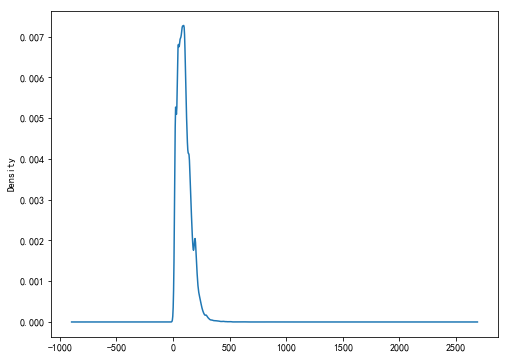

In [12]:
plt.figure(figsize=(8, 6))
train_test['用户近6个月平均消费值（元）'].plot(kind='kde')

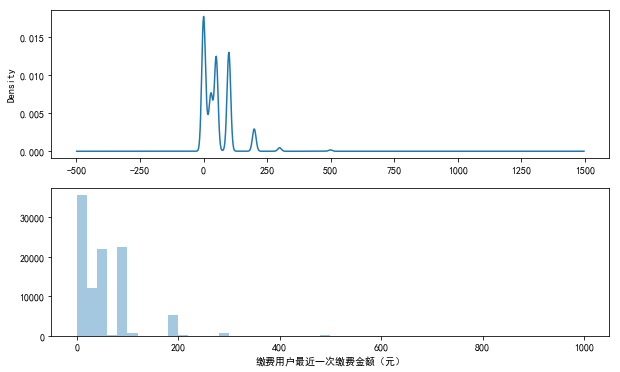

In [13]:
fig, axes = plt.subplots(2, 1, figsize=(10, 6))
train_df['缴费用户最近一次缴费金额（元）'].plot(kind='kde', ax=axes[0])
sns.distplot(train_test['缴费用户最近一次缴费金额（元）'], bins=50, kde=False, ax=axes[1])

C:\Users\hotheat\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


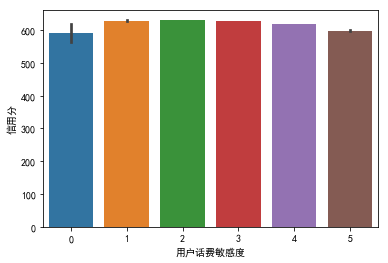

In [14]:
sns.barplot(data=train_df, x='用户话费敏感度', y='信用分')

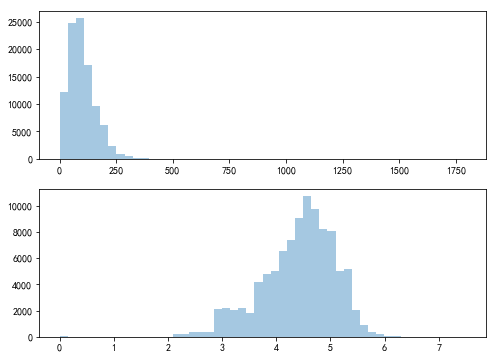

In [15]:
fig, axes = plt.subplots(2, 1,figsize=(8, 6))
sns.distplot(train_test['用户近6个月平均消费值（元）'].values, bins=50, kde=False, ax=axes[0])
sns.distplot(np.log1p(train_test['用户近6个月平均消费值（元）'].values), bins=50, kde=False, ax=axes[1])

做对数处理变换后，有点像正态分布

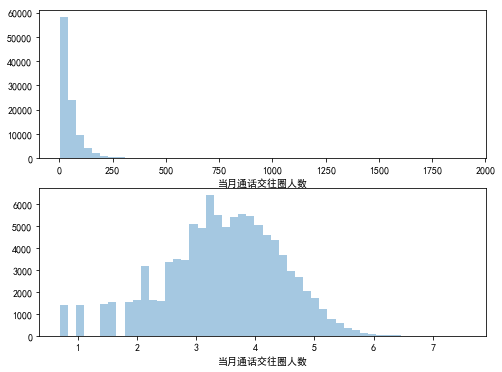

In [16]:
fig, axes = plt.subplots(2, 1, figsize=(8, 6))
sns.distplot(train_test['当月通话交往圈人数'], bins=50, kde=False, ax=axes[0])
sns.distplot(np.log1p(train_test['当月通话交往圈人数']), bins=50, kde=False, ax=axes[1])

当月通话交往圈人数/用户近6个月平均消费值（元）/缴费用户最近一次缴费金额（元）等数据出现一些异常值，样本数量又很少。可能会影响模型的鲁棒性。
使训练集和测试集数据上不是同分布。

## 二分类特征

对于二分类变量，观察与信用分的关系

In [17]:
bi_cats = train_test.columns[train_test.nunique()==2]

In [18]:
bi_cats

Index(['用户实名制是否通过核实', '是否大学生客户', '是否黑名单客户', '是否4G不健康客户', '用户最近一次缴费距今时长（月）',
       '缴费用户当前是否欠费缴费', '是否经常逛商场的人', '当月是否逛过福州仓山万达', '当月是否到过福州山姆会员店', '当月是否看电影',
       '当月是否景点游览', '当月是否体育场馆消费'],
      dtype='object')

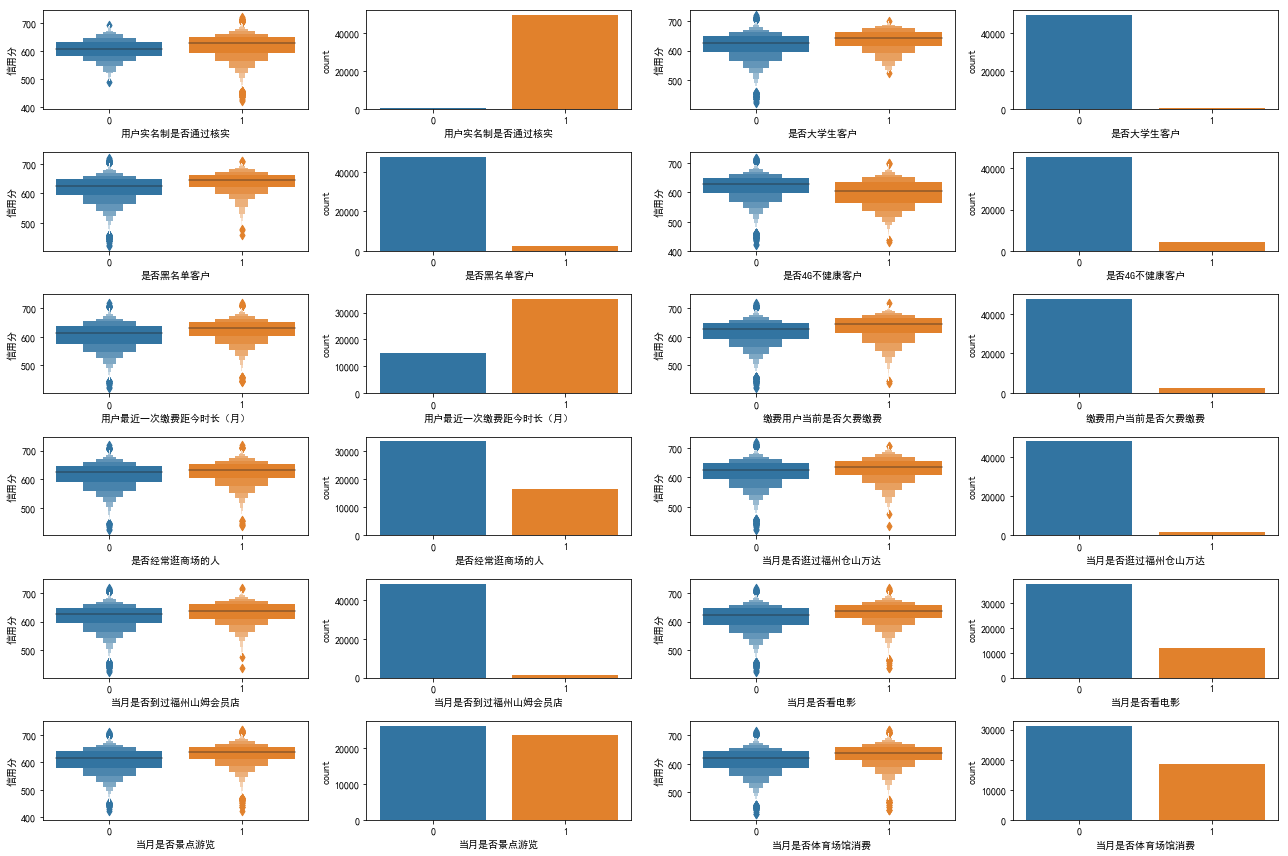

In [19]:
fig, axes = plt.subplots(6, 4, figsize=(18, 12))
for i, ax in zip(bi_cats, axes.reshape(-1, 2)):
    sns.boxenplot(ax=ax[0], data=train_df, y='信用分', x=i)
    sns.countplot(ax=ax[1], data=train_df, x=i)
plt.tight_layout()

这些类别变量数量分布大部分差异比较大的。  
比较奇怪的是黑名单客户，最近一个月欠费缴费的信用分比较高。  
最近一次缴费距今时长，是否景点游览，是否看电影，是否体育场馆消费，label 差异大，可能是重要的特征

C:\Users\hotheat\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


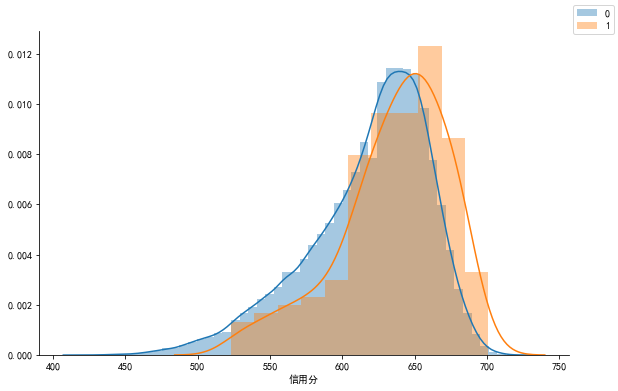

In [20]:
g = sns.FacetGrid(train_df, hue='是否大学生客户')
g.map(sns.distplot, '信用分')
g.fig.set_size_inches(10, 6)
g.fig.legend()

从分布上来看是差不多的，大学生客户的信用分不低于 450 分

## 多分类特征

In [21]:
train_test['用户话费敏感度'].value_counts()

4    29838
5    21011
2    20622
3    20578
1     7913
0       38
Name: 用户话费敏感度, dtype: int64

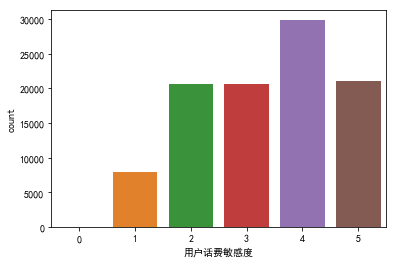

In [22]:
sns.countplot(data=train_test, x='用户话费敏感度')

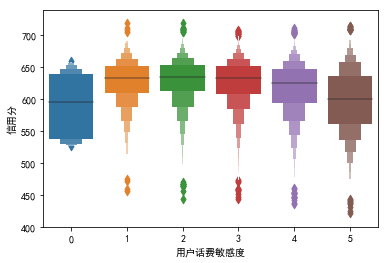

In [23]:
sns.boxenplot(data=train_df, x='用户话费敏感度', y='信用分')

话费敏感度是 0 与 5 的分布差不多，平均值也差不多，可以用 5 填充 0

## 数值型字段与目标变量的相关性

### 相关系数

这里不考虑布尔型变量，布尔型变量的 0 和 1 不代表实际大小关系

In [24]:
def show_corr(df, method='spearman', figsize=(10, 8), heatmap=False):
    train = pd.concat((df[:train_df.shape[0]], y_train), axis=1)
    corrs = train.corr(method=method)
    plt.figure(figsize=figsize)
    tmp_df = pd.DataFrame(corrs['信用分'].drop('信用分')).reset_index()
    tmp_df = tmp_df.rename(columns={'信用分':'相关性'})
    if not heatmap:
        sns.barplot(data=tmp_df.sort_values(by='相关性', ascending=False), x ='相关性', y = 'index')
    else:
        sns.heatmap(corrs, vmax=1, square=True)

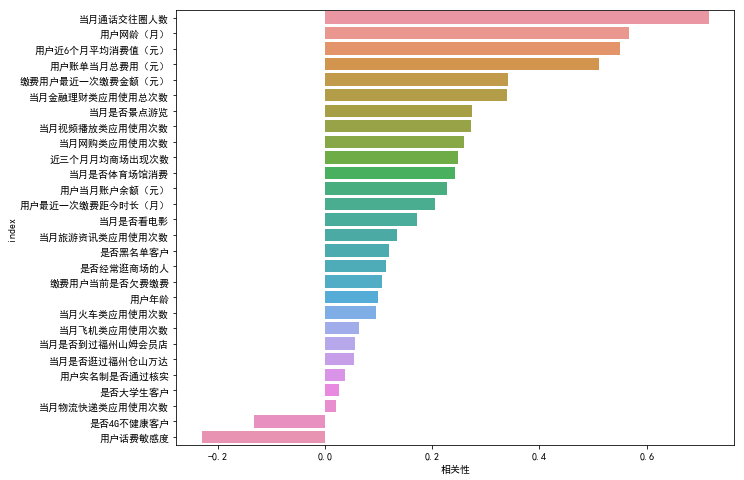

In [25]:
show_corr(train_df.drop('信用分', axis=1))

当月通话交往圈人数和用户网龄是相关性系数最高的特征。和费用相关的特征是相关性比较高的特征

### 检查数值型等于 0 的情况

猜测等于 0 可能是缺失值

In [26]:
feats = train_df.columns[(train_df.min()==0)&(train_df.nunique()>6)].tolist()

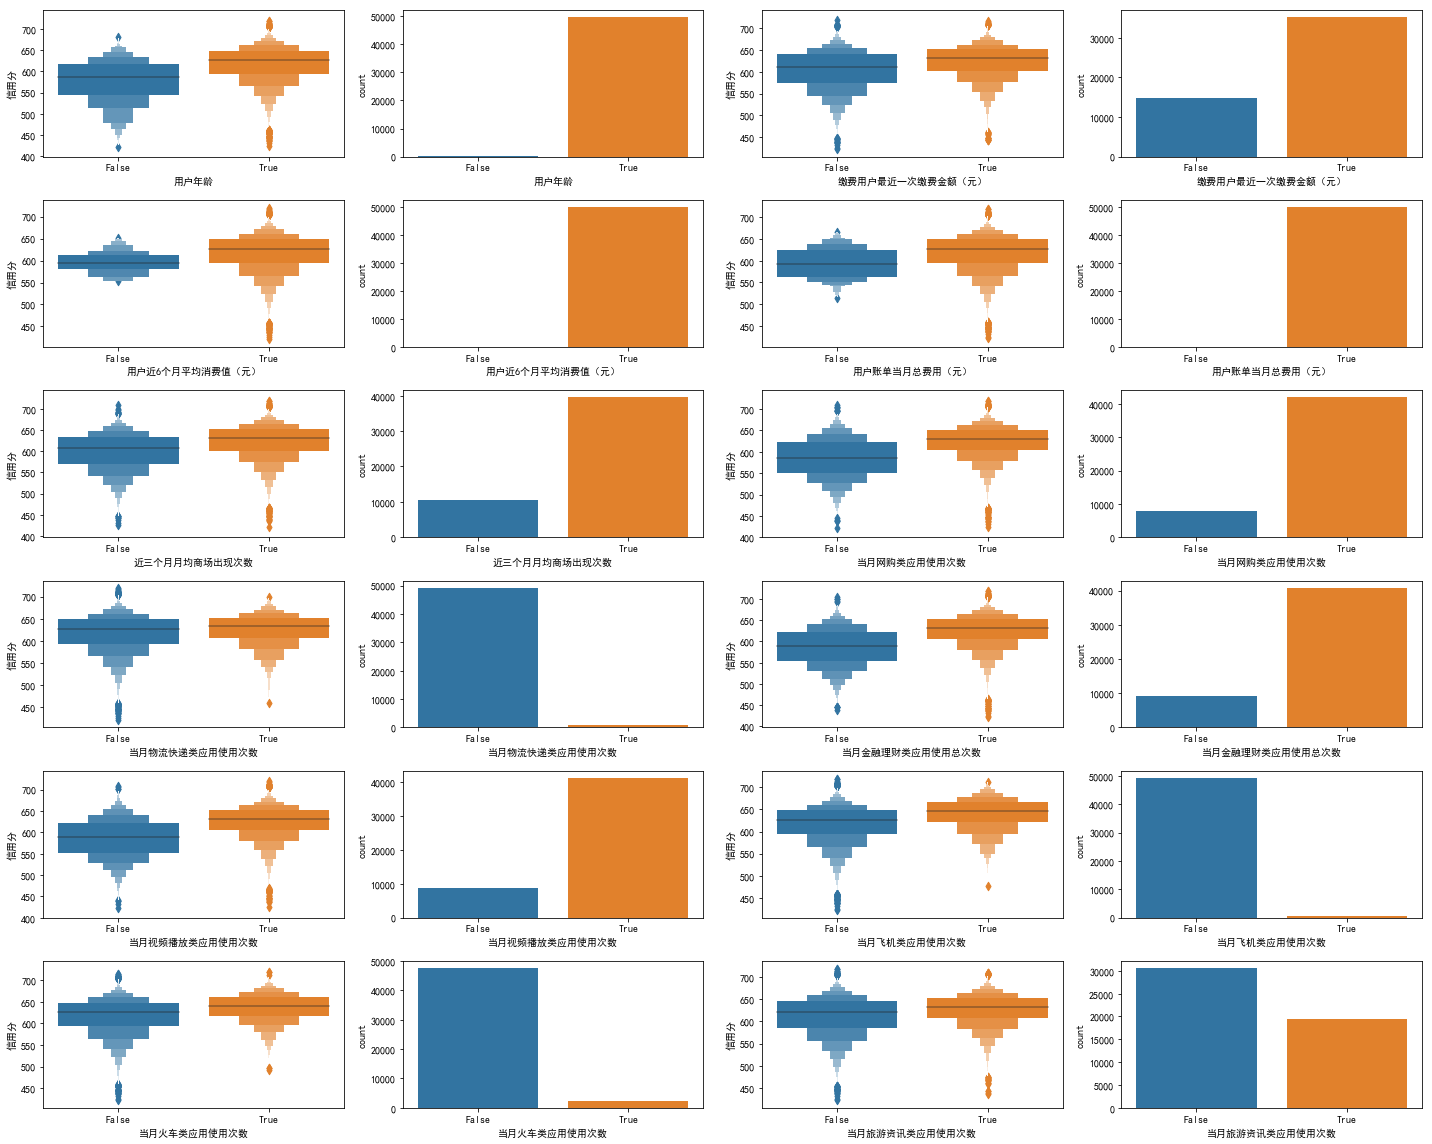

In [27]:
fig, axes = plt.subplots(6, 4, figsize=(20, 16))
for i, ax in zip(feats, axes.reshape(-1, 2)):
    sns.boxenplot(train_df[i]!=0, train_df['信用分'], ax=ax[0])
    sns.countplot(train_df[i]!=0, ax=ax[1])
    plt.tight_layout()

如果网购多，可能出行次数会少。

缴费用户最近一次缴费金额，近三个月商场出现次数，当月网购类使用次数，金融类应用使用次数，视频播放类应用使用次数进行二分化

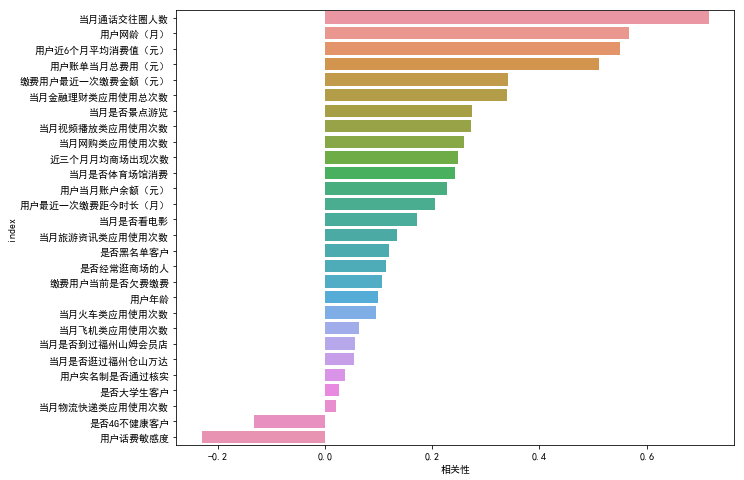

In [28]:
show_corr(train_test)

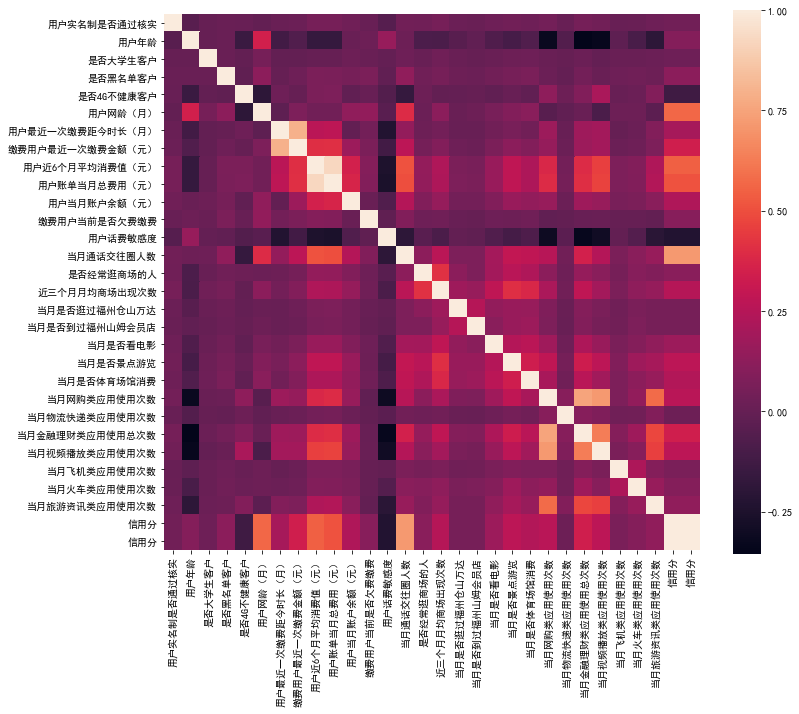

In [29]:
show_corr(train_df, figsize=(12, 10), heatmap=True)

从图来看，几乎没有什么特别大的共线性，如果出现相关系数接近 1 的，则要考虑去掉其中一个。

## 连续型特征与 label 线性关系

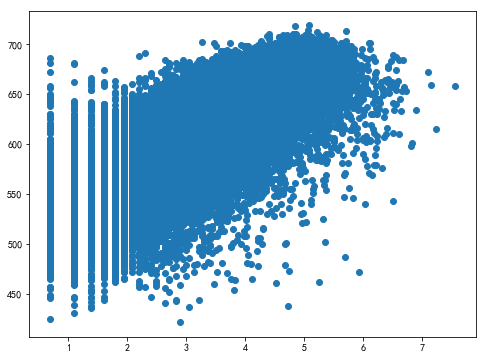

In [30]:
plt.figure(figsize=(8, 6))
plt.scatter(x=np.log1p(train_df['当月通话交往圈人数']), y=train_df['信用分'])

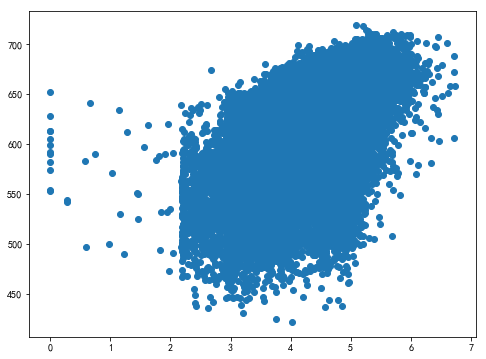

In [31]:
plt.figure(figsize=(8, 6))
plt.scatter(x=np.log1p(train_df['用户近6个月平均消费值（元）']), y=train_df['信用分'])

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(x=np.log1p(train_df['当月通话交往圈人数']), y=train_df['信用分'])

# 特征工程

In [30]:
train_test = train_test.drop('用户编码',axis=1)

对于匿名数据挖掘，可以对给定的字段进行加减乘除，开方和取平方等操作，但是对于给定含义的字段，没必要对每个字段进行交叉的加减乘除等操作。

In [31]:
train_test.loc[train_test['用户话费敏感度']==0, '用户话费敏感度'] = 5

## 年龄编码

In [32]:
# def parse_age(x):
#     if x == 0:
#         return 0
#     elif 0 < x <= 18:
#         return 1
#     elif x <= 30:
#         return 2
#     elif x <= 35:
#         return 3
#     elif x <= 45:
#         return 4
#     else:
#         return 5

# train_test['用户年龄'] = train_test['用户年龄'].apply(parse_age)

## 针对二分类特征

In [33]:
train_test['当月是否去过高档商场消费'] = train_test['当月是否逛过福州仓山万达'] + \
    train_test['当月是否到过福州山姆会员店']
train_test.loc[train_test['当月是否去过高档商场消费']>=1, '当月是否去过高档商场消费']=1
train_test['用户欠费缴费或黑名单'] = ((train_test['是否黑名单客户'] + train_test['缴费用户当前是否欠费缴费'])>=1).apply(int)

In [34]:
from itertools import combinations
bi_combine_lst = ['是否经常逛商场的人', '当月是否看电影', '当月是否景点游览', '当月是否体育场馆消费']
combine_iter = combinations(range(4), 2)


def parse_bifeature(df, col1, col2):
    df[col1+'或'+col2] = ((df[col1] * df[col2]) >= 1).apply(int)
    return df


for idx1, idx2 in combine_iter:
    col1, col2 = bi_combine_lst[idx1], bi_combine_lst[idx2]
    train_test = parse_bifeature(train_test, col1, col2)

In [35]:
train_test['商场_电影_景点'] = train_test['是否经常逛商场的人'] + \
    train_test['当月是否看电影']+train_test['当月是否景点游览']

train_test['商场_电影_体育馆'] = train_test['是否经常逛商场的人'] + \
    train_test['当月是否看电影']+train_test['当月是否体育场馆消费']

train_test['商场_体育馆_景点'] = train_test['是否经常逛商场的人'] + \
    train_test['当月是否体育场馆消费']+train_test['当月是否景点游览']

train_test['体育馆_电影_景点'] = train_test['当月是否体育场馆消费'] + \
    train_test['当月是否看电影']+train_test['当月是否景点游览']

train_test['体育馆_电影_景点_商场'] = train_test['当月是否体育场馆消费'] + \
    train_test['当月是否看电影']+train_test['当月是否景点游览'] + train_test['是否经常逛商场的人']

## 数值特征

### 是否发生

In [36]:
# equal0_feats = ['缴费用户最近一次缴费金额（元）', '近三个月月均商场出现次数', '当月网购类应用使用次数', '当月金融理财类应用使用总次数',
#                 '当月视频播放类应用使用次数', '当月旅游资讯类应用使用次数']

# for i in equal0_feats:
#     train_test['是否'+i] = (train_test[i] != 0).apply(int)

# train_test['飞机和火车类应用至少使用一个'] = (
#     ((train_test['当月飞机类应用使用次数'] != 0).apply(int) +
#      (train_test['当月火车类应用使用次数'] != 0).apply(int)) >= 1
# ).apply(int)

# train_test['金融和视频播放类应用是否同时都用'] = train_test['是否当月金融理财类应用使用总次数'] + \
#     train_test['是否当月视频播放类应用使用次数']
# train_test['金融和购物类应用是否同时都用'] = train_test['是否当月金融理财类应用使用总次数'] + \
#     train_test['是否当月网购类应用使用次数']
# train_test['视频播放和购物类应用是否同时都用'] = train_test['是否当月视频播放类应用使用次数'] +\
#     train_test['是否当月网购类应用使用次数']


# train_test['是否出现商场和视频播放类应用'] = train_test['是否近三个月月均商场出现次数'] + \
#     train_test['是否当月视频播放类应用使用次数']
# train_test['出现商场和购物类应用是否同时发生'] = train_test['是否近三个月月均商场出现次数'] * \
#     train_test['是否当月网购类应用使用次数']
# train_test['出现商场和视频播放类应用是否同时发生'] = train_test['是否当月视频播放类应用使用次数'] * \
#     train_test['是否近三个月月均商场出现次数']

# train_test['金融_视频播放_网购应用使用'] = train_test['是否当月金融理财类应用使用总次数'] + \
#     train_test['是否当月视频播放类应用使用次数']+train_test['是否当月网购类应用使用次数']
# train_test['金融_视频播放_网购应用_商场'] = train_test['是否当月金融理财类应用使用总次数'] * \
#     train_test['是否当月视频播放类应用使用次数'] * \
#     train_test['是否当月网购类应用使用次数']*train_test['是否近三个月月均商场出现次数']
# equal0_feat_flag = ['是否'+i for i in equal0_feats]
# train_test.drop(equal0_feat_flag, axis=1, inplace=True)

### 缴费金额和交通 APP 使用次数

In [37]:
train_test['缴费金额是否覆盖当月账单'] = train_test['缴费用户最近一次缴费金额（元）'] - \
    train_test['用户账单当月总费用（元）']
train_test['最近一次缴费是否超过平均消费额'] = train_test['缴费用户最近一次缴费金额（元）'] - \
    train_test['用户近6个月平均消费值（元）']
train_test['当月账单是否超过平均消费额'] = train_test['用户账单当月总费用（元）'] - \
    train_test['用户近6个月平均消费值（元）']

In [38]:
train_test['交通类APP使用次数'] = train_test['当月飞机类应用使用次数'] + train_test['当月火车类应用使用次数']

### 离散化

75% 分位数等于0的特征，而且有很大的异常值离散化。离散化使得粒度变粗，可以防止过拟合。

In [39]:
lst = ['交通类APP使用次数', '当月物流快递类应用使用次数',
       '当月飞机类应用使用次数', '当月火车类应用使用次数', '当月旅游资讯类应用使用次数']

In [40]:
def discreteze(x):
    if x == 0:
        return 0
    elif x<=5:
        return 1
    elif x<=15:
        return 2
    elif x<=50:
        return 3
    elif x<=100:
        return 4
    else:
        return 5

In [41]:
for i in lst:
    train_test[i] = train_test[i].apply(discreteze)

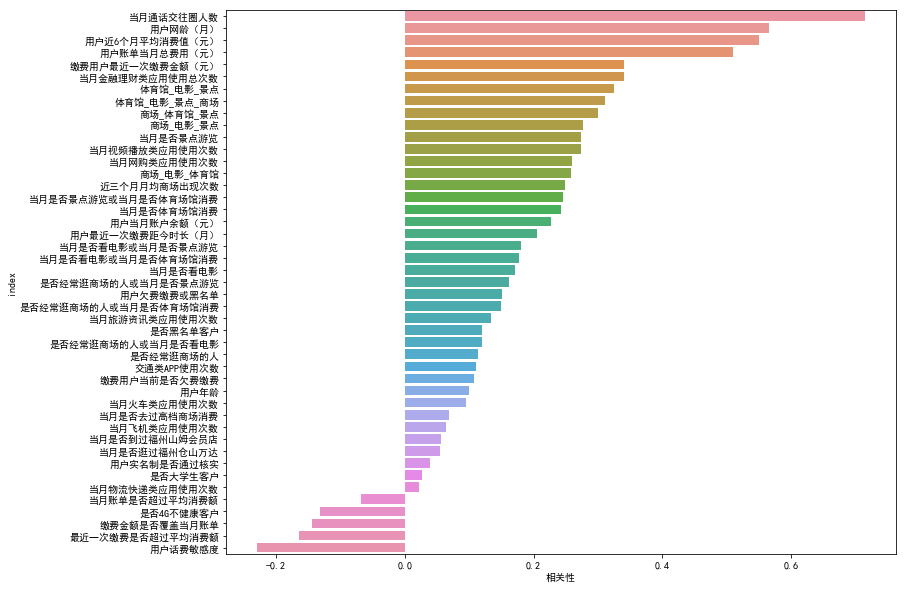

In [42]:
show_corr(train_test, figsize=(12, 10))

## 数据处理

### 针对长尾分布和异常大值过滤

主要包括对长尾分布取 log，采用分位数对异常值进行过滤

In [43]:
def base_process(data):
    transform_value_feature = ['用户年龄', '用户网龄（月）', '当月通话交往圈人数', '最近一次缴费是否超过平均消费额', 
                               '当月账单是否超过平均消费额', '近三个月月均商场出现次数', '当月网购类应用使用次数',
                               '当月物流快递类应用使用次数', '当月金融理财类应用使用总次数', 
                               '当月视频播放类应用使用次数', '当月飞机类应用使用次数', '当月火车类应用使用次数', 
                               '当月旅游资讯类应用使用次数']
    user_bill_fea = ['缴费用户最近一次缴费金额（元）', '用户近6个月平均消费值（元）',
                     '用户账单当月总费用（元）', '用户当月账户余额（元）']
    log_features = ['当月网购类应用使用次数', '当月金融理财类应用使用总次数', '当月视频播放类应用使用次数',
                    ]
    for col in transform_value_feature + log_features+user_bill_fea:
        ulimit = np.percentile(data[col].values, 99.9)
        llimit = np.percentile(data[col].values, 0.1)
        data.loc[train_test[col] > ulimit, col] = ulimit
        data.loc[train_test[col] < llimit, col] = llimit

    for col in user_bill_fea+log_features:
        data[col] = np.log1p(data[col])
    return data


train_test = base_process(train_test)

# 模型预测

train_data 与 test_data 预测结果的分布可能有差异。  
回归树的每个叶节点样本的平均值作为回归预测的预测值。比最大值小，比最小值大，所以分布范围会比训练集上窄。  
如果预测值的长尾分布比较严重，可以试着用神经网络和树模型做融合。  

## 只用 MAE 结果

In [44]:
lgb_params = {
    'objective': 'regression',
    'boosting_type':'gbdt', 
    'num_leaves': 31,
    'reg_alpha': 2.2,
    'reg_lambda': 1.5, 
    'max_depth': 8, 
    'n_estimators': 2000, 
    'subsample': 0.8, 
    'colsample_bytree': 0.7,
    'subsample_freq': 1, 
    'learning_rate':0.03, 
    'random_state': 2019, 
    'n_jobs':-1
}

正则 L1 和 L2 参数 reg_alpha 和 reg_lambda，列采样 colsample_bytree 是比较敏感的。学习率建议设置的小一些。
mse 对于预测错误值较大的的结果惩罚力度较大，可能采用对二者预测结果融合的方式进行。

In [45]:
x_train, y_train, x_test = train_test[:train_df.shape[0]
                                      ], y_train, train_test[train_df.shape[0]:]

In [46]:
lgb = LGBMRegressor
lgbwrapper = GbmWrapper(lgb, params=lgb_params)
lgb_train, lgb_test = ModelRun(n_fold=10).run_oof(lgbwrapper, x_train.values, y_train.values, x_test.values)

lightGBM


C:\Users\hotheat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


1: Train 0.0691908 Val 0.0622457/0.0622457
--------------------------------------------------
2: Train 0.0707052 Val 0.0626197/0.0624327
--------------------------------------------------
3: Train 0.0712424 Val 0.0642371/0.0630341
--------------------------------------------------
4: Train 0.0698983 Val 0.0630587/0.0630403
--------------------------------------------------
5: Train 0.0695214 Val 0.0637510/0.0631824
--------------------------------------------------
6: Train 0.0700453 Val 0.0651449/0.0635095
--------------------------------------------------
7: Train 0.0708170 Val 0.0640909/0.0635926
--------------------------------------------------
8: Train 0.0681761 Val 0.0646354/0.0637229
--------------------------------------------------
9: Train 0.0698302 Val 0.0643209/0.0637894
--------------------------------------------------
10: Train 0.0680074 Val 0.0642091/0.0638313
--------------------------------------------------
Train:  [0.06919077700446927, 0.07070515855244813, 0.071242

## MAE 和 RMSE

In [47]:
lgb_params2 = {
    'objective': 'regression',
    'boosting_type':'gbdt', 
    'num_leaves': 31,
    'reg_alpha': 1.2,
    'reg_lambda': 1.8, 
    'max_depth': 8, 
    'n_estimators': 2000, 
    'subsample': 0.8, 
    'colsample_bytree': 0.7,
    'subsample_freq': 1, 
    'learning_rate':0.03, 
    'random_state': 2019, 
    'n_jobs':-1
}

In [48]:
lgb2 = LGBMRegressor
lgbwrapper2 = GbmWrapper(lgb2, params=lgb_params2, eval_metric='rsme')
lgb_train, lgb_test = ModelRun(n_fold=10).run_oof(
    lgbwrapper, x_train.values, y_train.values, x_test.values, clf2=lgbwrapper2)

lightGBM


C:\Users\hotheat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


mae 预测 [543.34751535 656.63506694 636.48303766 578.7582042  569.12877395]
mse 预测 [543.84883983 657.09625419 637.30594238 582.54943183 571.93286774]
merge后预测 [543.69844248 656.95789801 637.05907097 581.41206354 571.0916396 ]
y 实际值 [530 649 648 547 599]
1: Train 0.0725526 Val 0.0622444/0.0622444
--------------------------------------------------
mae 预测 [666.61218177 616.08871187 510.63272882 680.25792458 517.31579505]
mse 预测 [666.26826183 613.78008164 509.02312909 680.96528871 513.29652694]
merge后预测 [666.37143781 614.4726707  509.50600901 680.75307947 514.50230737]
y 实际值 [692 600 523 692 518]
2: Train 0.0710994 Val 0.0626119/0.0624281
--------------------------------------------------
mae 预测 [657.67770997 672.33942443 495.73610855 502.74282999 558.67911941]
mse 预测 [658.14116417 672.2588079  495.60497956 503.62474699 558.24116384]
merge后预测 [658.00212791 672.28299286 495.64431826 503.36017189 558.37255051]
y 实际值 [692 698 523 523 523]
3: Train 0.0714846 Val 0.0641923/0.0630162
-------------

In [49]:
train_test.to_csv('baseline.csv', index=False)

## 贝叶斯优化超参数

In [75]:
adj_params = {'min_child_weight': (5, 50),
              'colsample_bytree': (0.4, 1),
              'max_depth': (4, 10),
              'subsample': (0.5, 1),
              'reg_lambda': (0.2, 2.5),
              'reg_alpha': (0.2, 2),
              'learning_rate':(0.003,0.2), 
              'min_child_samples': (10, 30)}

In [81]:
kf = StratifiedKFold(n_splits=5, shuffle=False)
eval_func = mean_absolute_error
xtrain_value, ytrain_value = x_train.values, y_train.values
for train_index, test_index in kf.split(xtrain_value, ytrain_value):
    x_tr = xtrain_value[train_index]
    x_te = xtrain_value[test_index]
    y_tr = ytrain_value[train_index]
    y_te = ytrain_value[test_index]
    lgbwrapper.optimize(x_tr, y_tr, x_te, y_te, adj_params, eval_func)

C:\Users\hotheat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|   iter    |  target   | colsam... | max_depth | min_ch... | min_ch... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -15.4     |  0.9198   |  9.384    |  27.43    |  8.5      |  0.5201   |  0.5181   |  0.8931   |
|  2        | -15.38    |  0.634    |  8.761    |  19.18    |  16.18    |  1.171    |  2.075    |  0.9898   |
|  3        | -15.42    |  0.7977   |  8.423    |  21.77    |  12.4     |  0.6332   |  0.5732   |  0.9565   |
|  4        | -15.42    |  0.8942   |  7.102    |  24.38    |  4.192    |  1.409    |  2.472    |  0.5169   |
|  5        | -15.41    |  0.9501   |  8.523    |  20.12    |  19.18    |  0.223    |  1.245    |  0.7589   |
|  6        | -15.36    |  0.4      |  10.0     |  10.0     |  3.0      |  0.2      |  2.5      |  1.0      |
|  7        | -15.44    |  1.0      |  10.0     |  10.0     |  20.0     |  2.0      |  2.5      |  0.5      |
|  8      

|  45       | -15.37    |  0.4      |  3.0      |  22.3     |  11.09    |  2.0      |  2.5      |  1.0      |
|  46       | -15.36    |  0.4      |  9.591    |  30.0     |  14.07    |  2.0      |  0.9712   |  1.0      |
|  47       | -15.34    |  0.4      |  4.859    |  12.78    |  20.0     |  0.2      |  1.293    |  1.0      |
|  48       | -15.36    |  0.4      |  6.642    |  10.0     |  20.0     |  0.2      |  2.5      |  1.0      |
|  49       | -15.38    |  0.7946   |  3.702    |  10.0     |  18.83    |  0.3752   |  0.587    |  0.9637   |
|  50       | -15.38    |  0.4      |  5.716    |  16.81    |  20.0     |  0.2      |  0.7402   |  1.0      |
|  51       | -15.36    |  0.4      |  10.0     |  25.48    |  16.16    |  0.2      |  0.5155   |  1.0      |
|  52       | -15.37    |  0.4      |  9.39     |  23.12    |  16.9     |  0.3937   |  2.5      |  1.0      |
|  53       | -15.35    |  0.4301   |  4.111    |  12.45    |  19.72    |  1.625    |  1.993    |  0.9947   |
|  54     

KeyboardInterrupt: 